In [11]:
import pickle
import warnings

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from itertools import combinations, product
from scipy.spatial import distance
from scipy import stats
from annoy import AnnoyIndex

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [4]:
embeds, rows = [], []

for path in tqdm(glob('../data/b7-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)
        
        for line in lines:
            title = ' '.join(line['tokens'])
            embeds.append(line['embedding'])
            rows.append((line['label'], line['count'], title))

100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows, columns=('label', 'count', 'title'))

In [7]:
df.label.unique()

array(['breitbart.com', 'cnn.com', 'huffingtonpost.com', 'apnews.com',
       'reuters.com', 'nytimes.com', 'foxnews.com'], dtype=object)

In [8]:
embeds.shape

(500000, 512)

In [18]:
fox_df = df[df.label=='foxnews.com']
nyt_df = df[df.label=='nytimes.com']

In [26]:
idx = AnnoyIndex(embeds.shape[1])

for id in tqdm(df[df.label.isin(['foxnews.com', 'nytimes.com'])].index):
    idx.add_item(id, embeds[id])
    
idx.build(10)

100%|██████████| 142922/142922 [00:11<00:00, 12253.05it/s]


True

In [29]:
nyt_df.index

Int64Index([     8,      9,     19,     34,     35,     41,     56,     65,
                71,     74,
            ...
            499927, 499935, 499939, 499941, 499948, 499957, 499963, 499967,
            499977, 499987],
           dtype='int64', length=71640)

In [56]:
ratios = []
for id in tqdm(nyt_df.head(20000).index):

    s, o = 0, 0
    for nn_id in idx.get_nns_by_item(id, 100):
        if df.iloc[nn_id].label == 'nytimes.com':
            s += 1
        else:
            o += 1

    ratios.append(s / (s + o))

100%|██████████| 20000/20000 [04:46<00:00, 69.75it/s]


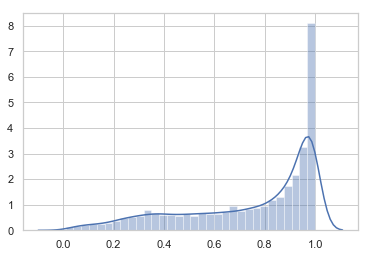

In [57]:
sns.distplot(ratios)

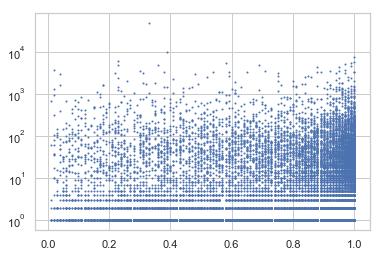

In [58]:
plt.yscale('log')
plt.scatter(ratios, nyt_df.head(len(ratios))['count'], s=1)

In [59]:
stats.pearsonr(ratios, nyt_df.head(len(ratios))['count'])

(-0.01070921400602995, 0.1299091270867272)